In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import shap
shap.initjs()

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn import tree

from itertools import product

from tqdm import tqdm

In [2]:
# evaluation metric
disp_err = np.vectorize(lambda a,b: abs(a/b - 1)) # a - predicted, b - true

In [3]:
# Load Data and split into train val and test sets
data = pd.read_csv('../data/features.csv', index_col='Date')

In [4]:
X = data.to_numpy()
# data1[:, 1:], data1[:, 0]

In [5]:
from sklearn.model_selection import train_test_split

# Split into 70:20:10
train, temp = train_test_split(X, shuffle=False, test_size=0.3)
val, test = train_test_split(temp, shuffle=False, test_size=0.333)

print(f'Train Data: X - {train[:, 1:].shape}, y - {train[:, 0].shape}')
print(f'Val Data: X - {val[:, 1:].shape}, y - {val[:, 0].shape}')
print(f'Test Data: X - {test[:, 1:].shape}, y - {test[:, 0].shape}')

Train Data: X - (69, 22), y - (69,)
Val Data: X - (20, 22), y - (20,)
Test Data: X - (10, 22), y - (10,)


In [6]:
dat = np.concatenate((train, val))
dat.shape

(89, 23)

### XGBoost Regressor

In [7]:
# hyper parameter tuning
n_choices = [50, 100, 250, 500, 1000]
depth_choices = [5, 10, 20, 30]

best_err, best_params = np.inf, (None, None)

for n, d in tqdm(product(n_choices, depth_choices),
                 total=len(n_choices)*len(depth_choices)):
    xgb_model = XGBRegressor(n_estimators=n, max_depth=d, random_state=0)
    xgb_model.fit(train[:, 1:], train[:, 0])
    
    preds = xgb_model.predict(val[:, 1:])
    err = np.mean(disp_err(preds, val[:, 0]))
    if err < best_err:
        best_err = err
        best_params = (n, d)  
        
best_params

100%|██████████████████████████████████████| 20/20 [00:03<00:00,  5.66it/s]


(100, 20)

In [8]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=20, random_state=0)
xgb_model.fit(dat[:, 1:], dat[:, 0]) # train on train + val data after tuning

preds = xgb_model.predict(test[:, 1:])
print('Dispersion on Test Data:', np.mean(disp_err(preds, test[:, 0])))
print('RMSE on Test Data:', mean_squared_error(preds, test[:, 0], squared=False))
print()
preds = xgb_model.predict(dat[:, 1:])
print('Dispersion on Train+Val Data:', np.mean(disp_err(preds, dat[:, 0])))
print('RMSE on Train+Val Data:', mean_squared_error(preds, dat[:, 0], squared=False))

Dispersion on Test Data: 0.08971042512382138
RMSE on Test Data: 12.433314678591067

Dispersion on Train+Val Data: 6.730022556985977e-06
RMSE on Train+Val Data: 0.0005068612247829083


This model is clearly overfitting the data

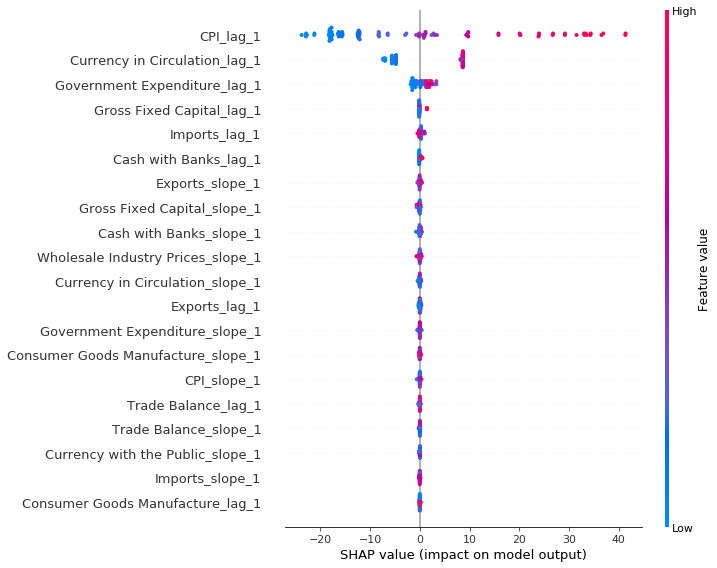

In [9]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(dat[:, 1:])
shap.summary_plot(shap_values, features=dat[:, 1:], feature_names=data.columns[1:])

### Random Forest Regressor

In [10]:
# hyper parameter tuning
n_choices = [500, 1000, 5000, 10000]
depth_choices = [5, 10, 20, 30]

best_err, best_params = np.inf, (None, None)

for n, d in tqdm(product(n_choices, depth_choices),
                 total=len(n_choices)*len(depth_choices)):
    rf_model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=0)
    rf_model.fit(train[:, 1:], train[:, 0])
    
    preds = rf_model.predict(val[:, 1:])
    err = np.mean(disp_err(preds, val[:, 0]))
    if err < best_err:
        best_err = err
        best_params = (n, d)  
        
best_params

100%|██████████████████████████████████████| 16/16 [01:28<00:00,  5.51s/it]


(5000, 5)

In [11]:
rf_model = RandomForestRegressor(n_estimators=5000, max_depth=5, random_state=0)
rf_model.fit(dat[:, 1:], dat[:, 0]) # train on train + val data after tuning

preds = rf_model.predict(test[:, 1:])
print('Dispersion on Test Data:', np.mean(disp_err(preds, test[:, 0])))
print('RMSE on Test Data:', mean_squared_error(preds, test[:, 0], squared=False))
print()
preds = rf_model.predict(dat[:, 1:])
print('Dispersion on Train+Val Data:', np.mean(disp_err(preds, dat[:, 0])))
print('RMSE on Train+Val Data:', mean_squared_error(preds, dat[:, 0], squared=False))

Dispersion on Test Data: 0.1257052658130904
RMSE on Test Data: 17.91308202643662

Dispersion on Train+Val Data: 0.006324935039160005
RMSE on Train+Val Data: 0.6704983289055513


This model is also overfitting the data, but not as much as the previous one

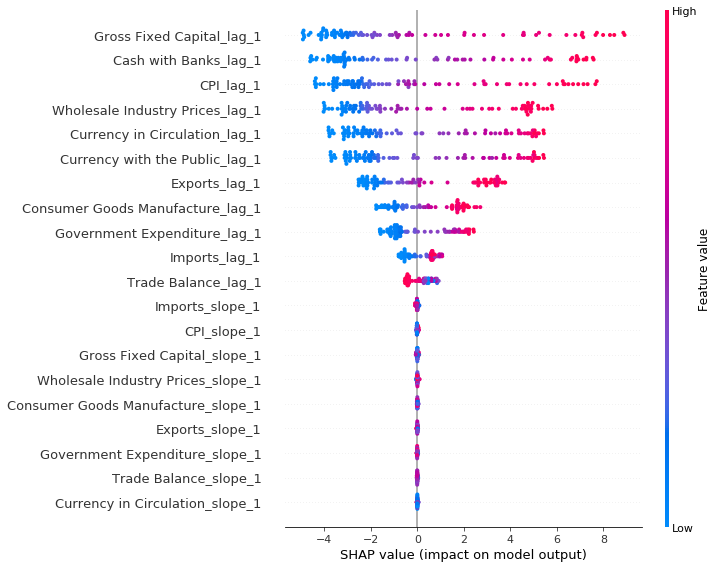

In [12]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(dat[:, 1:])
shap.summary_plot(shap_values, features=dat[:, 1:], feature_names=data.columns[1:])

**Observation**: XGBoost predictions majorly rely on only 2-3 features, but Random Forest employs more features to make predictions

### XGBRF regressor

In [13]:
# hyper parameter tuning
n_choices = [10, 25, 50, 75, 100]
depth_choices = [3, 5, 10, 20]

best_err, best_params = np.inf, (None, None)

for n, d in tqdm(product(n_choices, depth_choices),
                 total=len(n_choices)*len(depth_choices)):
    xgbrf_model = XGBRFRegressor(n_estimators=n, max_depth=d, random_state=0)
    xgbrf_model.fit(train[:, 1:], train[:, 0])
    
    preds = xgbrf_model.predict(val[:, 1:])
    err = np.mean(disp_err(preds, val[:, 0]))
    if err < best_err:
        best_err = err
        best_params = (n, d)  
        
best_params

100%|██████████████████████████████████████| 20/20 [00:01<00:00, 12.07it/s]


(50, 5)

In [14]:
xgbrf_model = XGBRFRegressor(n_estimators=50, max_depth=5, random_state=0)
xgbrf_model.fit(dat[:, 1:], dat[:, 0]) # train on train + val data after tuning

preds = xgbrf_model.predict(test[:, 1:])
print('Dispersion on Test Data:', np.mean(disp_err(preds, test[:, 0])))
print('RMSE on Test Data:', mean_squared_error(preds, test[:, 0], squared=False))
print()
preds = xgbrf_model.predict(dat[:, 1:])
print('Dispersion on Train+Val Data:', np.mean(disp_err(preds, dat[:, 0])))
print('RMSE on Train+Val Data:', mean_squared_error(preds, dat[:, 0], squared=False))

Dispersion on Test Data: 0.10640573750964136
RMSE on Test Data: 15.65828894200885

Dispersion on Train+Val Data: 0.005284637994149773
RMSE on Train+Val Data: 0.3903327643062174


This model also overfits the data

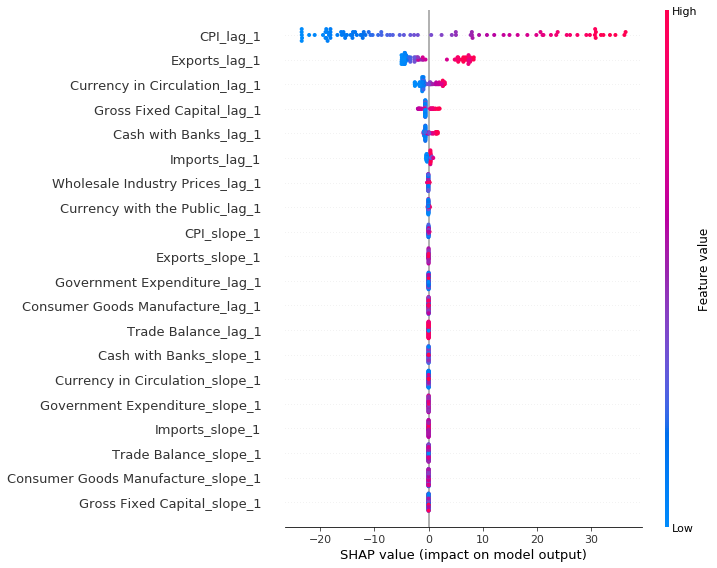

In [15]:
explainer = shap.TreeExplainer(xgbrf_model)
shap_values = explainer.shap_values(dat[:, 1:])
shap.summary_plot(shap_values, features=dat[:, 1:], feature_names=data.columns[1:])

### MLP Regressor

In [16]:
# hyper parameter tuning
hid_sizes = [256, 512, 1024, 2048]
options = [(n,) for n in hid_sizes] + [(n,)*2 for n in hid_sizes]


best_err, best_params = np.inf, None

for hid in tqdm(options):
    mlp_model = MLPRegressor(hidden_layer_sizes=hid, random_state=0)
    mlp_model.fit(train[:, 1:], train[:, 0]) # train on train + val data after tuning
    
    preds = mlp_model.predict(val[:, 1:])
    err = np.mean(disp_err(preds, val[:, 0]))
    if err < best_err:
        best_err = err
        best_params = hid
        
best_params

100%|████████████████████████████████████████| 8/8 [00:10<00:00,  1.26s/it]


(1024, 1024)

In [17]:
mlp_model = MLPRegressor(hidden_layer_sizes=(1024, 1024), random_state=0)
mlp_model.fit(dat[:, 1:], dat[:, 0]) # train on train + val data after tuning

preds = mlp_model.predict(test[:, 1:])
print('Dispersion on Test Data:', np.mean(disp_err(preds, test[:, 0])))
print('RMSE on Test Data:', mean_squared_error(preds, test[:, 0], squared=False))
print()
preds = mlp_model.predict(dat[:, 1:])
print('Dispersion on Train+Val Data:', np.mean(disp_err(preds, dat[:, 0])))
print('RMSE on Train+Val Data:', mean_squared_error(preds, dat[:, 0], squared=False))

Dispersion on Test Data: 0.009960279549164498
RMSE on Test Data: 1.3552280617806982

Dispersion on Train+Val Data: 0.011994650188679675
RMSE on Train+Val Data: 0.9613914863913996


Almost no overfitting! We have found our **champion model**!

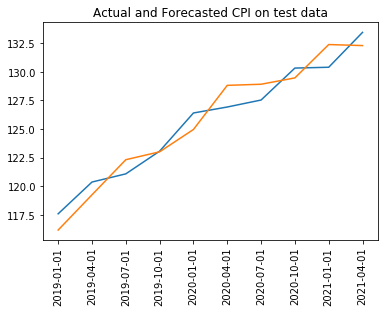

In [18]:
plt.plot(data.index.tolist()[-len(test):], X[:, 0][-len(test):], label='Actual')
plt.plot(data.index.tolist()[-len(test):], mlp_model.predict(test[:, 1:]), label='Forecasted')
plt.xticks(rotation=90)
plt.title('Actual and Forecasted CPI on test data')
plt.show()

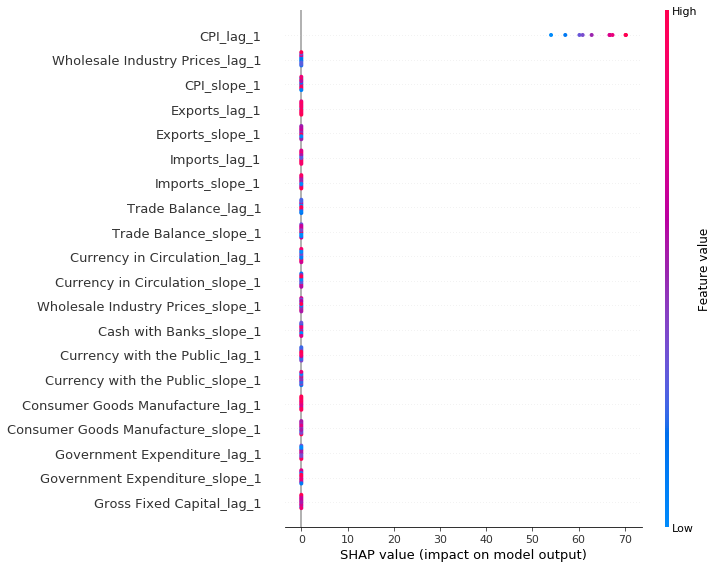

In [19]:
explainer = shap.KernelExplainer(mlp_model.predict, dat[:, 1:])
shap_values = explainer.shap_values(test[:, 1:],nsamples=100)
shap.summary_plot(shap_values, features=test[:, 1:], feature_names=data.columns[1:])